In [1]:
import import_ipynb
import plotting
import finite_difference_functions as fd_fct
import misc_functions as msc_fct
import Monte_Carlo_functions as mc_fct
import numpy as np
import matplotlib.pyplot as plt
import time

importing Jupyter notebook from plotting.ipynb
importing Jupyter notebook from finite_difference_functions.ipynb
importing Jupyter notebook from misc_functions.ipynb
importing Jupyter notebook from Monte_Carlo_functions.ipynb


### Setting up parameters

In [2]:
# initial various parameters
T = 60
Ndt = 100000
dt = T / Ndt

t_HJB = np.arange(0, T + dt, dt)
tau = T - t_HJB

# price jump sizes
sigma = 0.01

kappa = 100
xi = 0.01
alpha = 0.001

lamb = 50 / 60
Nq = 1
q = np.arange(0, Nq + 1, 1)
phi = 0.001

# AC Solution
phiAC = 10 ** (-5)
aAC = 0.001

qAC_HJB = msc_fct.AC_solver(phiAC, aAC, tau, T, Nq)

### HJB approach

In [3]:
t0 = time.clock()
# solve the QVI for omega
omega, exe = fd_fct.QVI_solver(t_HJB, dt, kappa, xi, phi, q, qAC_HJB, lamb)

# obtain the optimal time at which to execute market orders
t_opt = fd_fct.find_opt_t(exe, t_HJB)

# Solve for delta
delta_HJB = fd_fct.find_delta(kappa, omega, Nq, Ndt)

t1 = time.clock() - t0

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


### Monte Carlo approach

In [4]:
# changing grid
T = 60
Ndt = 6
dt = T / Ndt

t_MC = np.arange(0, T + dt, dt)
tau = T - t_MC

# imputing the monte carlo parameters
NSIM = 5000
actions = 10
confidence = 3000
conf = 500
epsilon = 0.4
S0 = 1
comp = 5

np.random.seed(100)

# simulating data
sim = mc_fct.sim_orders(dt, Ndt, NSIM, kappa, lamb)

# discretising the depth
sections, mid = mc_fct.discretisation(sim, actions)

# producing all possible state action pairs
state_actions = mc_fct.state_action(t_MC, q, Ndt, Nq, mid)

# selecting a ranomd policy
policy = mc_fct.rand_policy(state_actions, Ndt, dt, Nq)

# selecting multiple policies
policy_values = mc_fct.get_policies(policy, state_actions, Ndt, dt, Nq, confidence)

# getting the target inventory schedule
q_target = msc_fct.AC_solver(phiAC, kappa, tau, T, Nq)

np.random.seed(100)

# getting the optimal policy
pol, value, N, time, comparision = mc_fct.optimum_policy(policy_values, epsilon, state_actions, Ndt, dt, Nq, S0, sigma, xi, sim, q_target, phi, conf, comp)

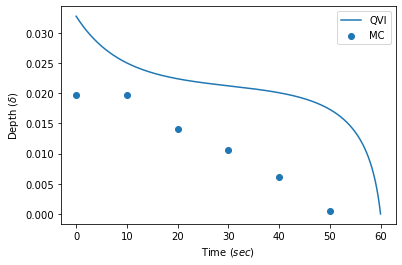

In [5]:
delta_mc = np.full(len(t_MC),np.nan)

for i in range(1, len(t_MC), 1):
    delta_mc[i] = pol[(i*dt,1)][1]

#plt.show()
plt.plot(t_HJB,delta_HJB[1])
plt.scatter(t_MC-dt, delta_mc)
plt.ylabel(r'Depth ($\delta$)')
plt.xlabel(r'Time ($sec$)')
plt.legend(['QVI','MC'])

Value function of HJB solution:

In [6]:
h = (1/kappa)*np.log(omega)
V = h[1,1] + S0*Nq
print(V)

1.0177658740367526


Value function of Monte Carlo method

In [7]:
print(value)

1.0041540496791623


Run time of HJB

In [8]:
print(t1)

5.696357600000001


Run time of Monte Carlo method

In [9]:
print(time)

1392.8712711


In [23]:
print(comparision)

[[1.00215283e+00 5.05000000e+02 4.26034459e-02]
 [1.00220962e+00 5.24000000e+02 2.30121659e-02]
 [1.00224732e+00 5.16000000e+02 2.74188547e-02]
 [1.00233646e+00 5.37000000e+02 1.77828648e-02]
 [1.00415405e+00 1.56000000e+03 8.79292097e-02]]


#### Script to produce t values

In [35]:
from scipy import stats
max_mean = comparision[:,0].max()
s = comparision[np.where(comparision[:,0] == max_mean),2][0][0] / comparision[np.where(comparision[:,0] == max_mean),1][0][0]
max_n = comparision[np.where(comparision[:,0] == max_mean),1][0][0]
t = []
for i in range(0,np.shape(comparision)[0],1):
    t.append((max_mean - comparision[i,0])/np.sqrt(s + comparision[i,2]/comparision[i,1]))
print(t)

pval = []
for i in range(0,len(t),1):
    n = min(max_n,comparision[i,1])
    pval.append(stats.t.sf(np.abs(t[i]), n-1))
print(pval)

[0.16869595285715408, 0.19417054038862036, 0.18221257033292218, 0.1921469041223611, 0.0]
[0.4330517404321313, 0.4230588719451307, 0.42774380415271007, 0.4238499542976941, 0.5]


#### Script to produce t values for twap approach

In [39]:
t_twap = (max_mean - 0.995)/(np.sqrt(s))
print(t_twap)
print(stats.t.sf(np.abs(t_twap), max_n-1))

1.219295523618058
0.11145824442147985
